In [67]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

In [68]:
# Load and display training data
train = pd.read_csv('../Data/Input/train.csv')
print('Training data shape:', train.shape)
train.head()

Training data shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [69]:
# Load and display testing data
test = pd.read_csv('../Data/Input/test.csv')
print('Testing data shape:', test.shape)
test.head()

Testing data shape: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [70]:
# Check missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [71]:
# Check missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### The ratio of missing values in test and training sets are around the same, we can assume that they were taken from the same sample

In [72]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


### The location column has too many missing and unique values, so I won't use it as a feature

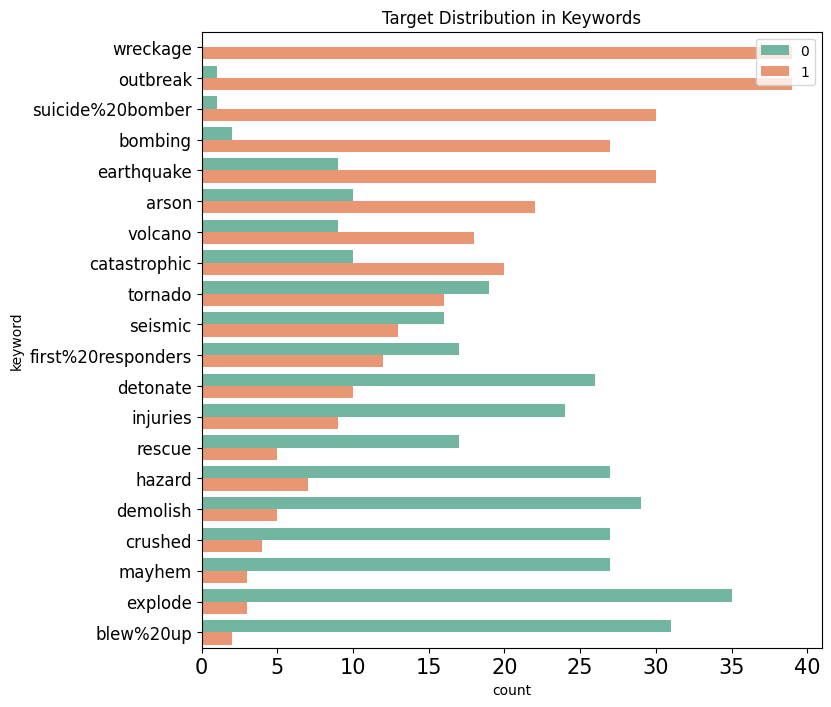

In [73]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

# Get 20 evenly distributed keywords
num_keywords = 20
unique_keywords = train['keyword'].unique()
step = len(unique_keywords) // num_keywords
selected_keywords = unique_keywords[::step]

filtered_train = train[train['keyword'].isin(selected_keywords)]

fig = plt.figure(figsize=(8, 8), dpi=100)

sns.countplot(y=filtered_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=filtered_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)


### The keyword column can be quite misleading. For example I would assume that the keywords 'explode', 'rescue' and 'crushed' are related to a disaster. However, by looking at the plot we can see that the tweets with these keywords were mostly labeled as non-disaster related. For now I wont use it as a feature

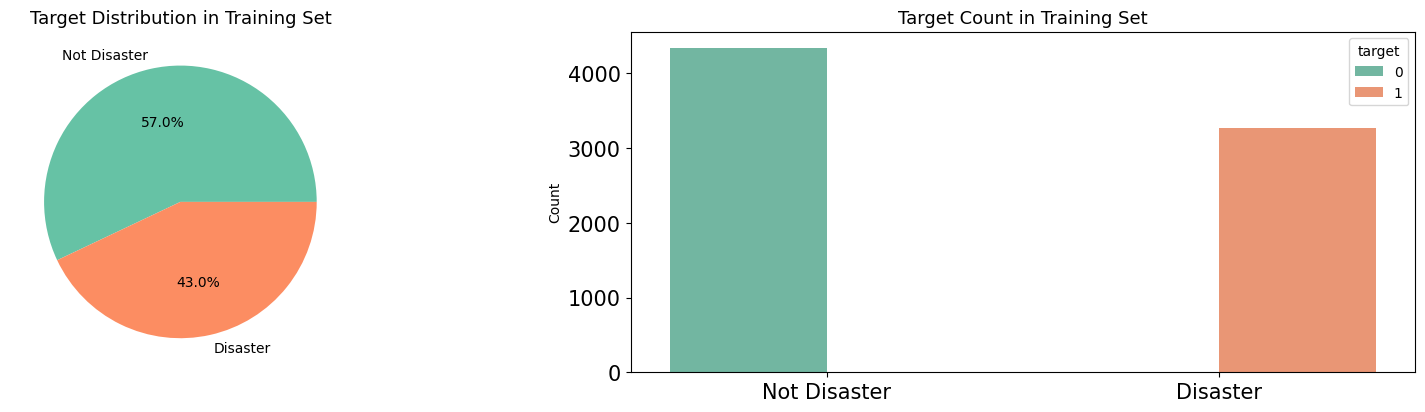

In [74]:
# Visualize target distribution
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train['target'].value_counts().plot(kind='pie', ax=axes[0], labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('Target Distribution in Training Set', fontsize=13)

sns.countplot(x='target', data=train, hue='target', ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Not Disaster', 'Disaster'])
axes[1].set_title('Target Count in Training Set', fontsize=13)

for ax in axes:
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.show()

In [75]:
# Display example disaster and non-disaster tweets
disaster_tweets = train[train['target'] == 1]['text']
print("Example disaster tweet:", disaster_tweets.values[1])

non_disaster_tweets = train[train['target'] == 0]['text']
print("Example non-disaster tweet:", non_disaster_tweets.values[1])

Example disaster tweet: Forest fire near La Ronge Sask. Canada
Example non-disaster tweet: I love fruits


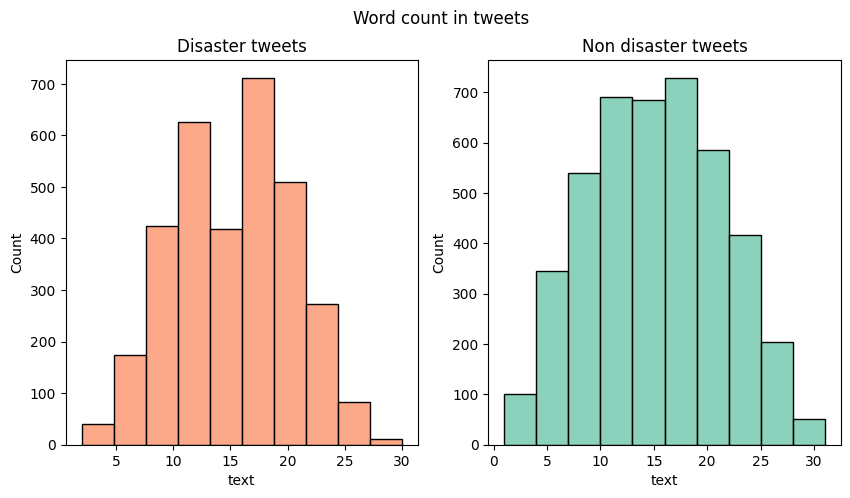

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len_disaster = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
tweet_len_non_disaster = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))

sns.histplot(tweet_len_disaster, ax=ax1, color=sns.color_palette()[1], bins=10) 
ax1.set_title('Disaster tweets')

sns.histplot(tweet_len_non_disaster, ax=ax2, color=sns.color_palette()[0], bins=10)
ax2.set_title('Non disaster tweets')

fig.suptitle('Word count in tweets')
plt.show()


TODO: experiment with feature engineering

In [77]:
# References:
# https://monkeylearn.com/blog/text-cleaning/
# https://stackoverflow.com/a/47091370
# https://stackoverflow.com/a/49146722


# Define function for text cleaning
def clean_text(text):
    #removal of url
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)

    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)

    # remove mentions
    text = re.sub('@\S+', '', text)
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)

    # Lowering all the words in text
    text = text.lower()

    return text

In [78]:
# Reference: https://stackoverflow.com/a/5486535


# Function for further text preprocessing
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    cleaned_text = clean_text(text)
    tokenized_text = tokenizer.tokenize(cleaned_text)
    filtered_text = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(filtered_text)
    return combined_text

In [79]:
# Apply text preprocessing to train and test datasets
train['text'] = train['text'].apply(lambda x: text_preprocessing(x))
test['text'] = test['text'].apply(lambda x: text_preprocessing(x))

In [80]:
print(train['text'].shape)
print(train['text'][0])

(7613,)
deeds reason earthquake may allah forgive us


In [81]:
# Create TF-IDF vectors
tfidf = TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1, 2), sublinear_tf=True)
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [82]:
print(train_tfidf.shape)

(7613, 62423)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, train["target"], test_size=0.2, random_state=42)

In [84]:
# Create and train a Multinomial Naive Bayes model
model = MultinomialNB(alpha=0.8)
model.fit(X_train, y_train)

MultinomialNB(alpha=0.8)

In [85]:
def plot_confusion_matrix_and_f1(y_true, y_pred, class_labels, title):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred)

    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title + ' -- F1 Score: ' + str(f1))
    plt.colorbar()

    # Add labels to the plot
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    # Label the cells with counts
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    # Show the plot
    plt.show()

Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      3468
           1       0.98      0.92      0.95      2622

    accuracy                           0.96      6090
   macro avg       0.96      0.96      0.96      6090
weighted avg       0.96      0.96      0.96      6090

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83       874
           1       0.83      0.65      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



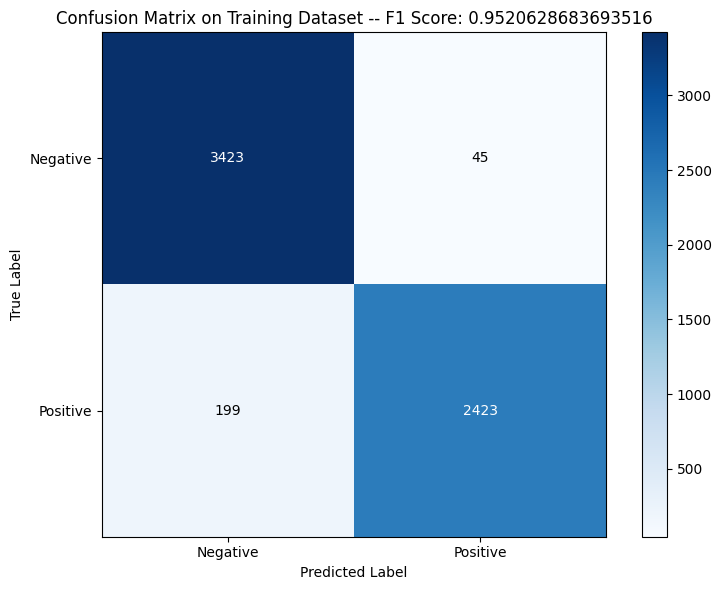

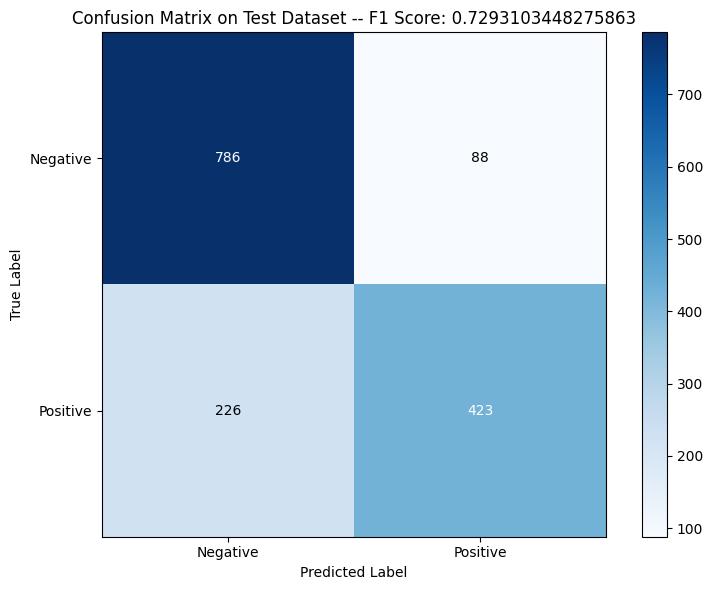

In [86]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print("Classification Report on Training Set:\n", report_train)
print("Classification Report on Test Set:\n", report_test)

class_labels = ['Negative', 'Positive']

plot_confusion_matrix_and_f1(y_train, y_pred_train, class_labels, 'Confusion Matrix on Training Dataset')
plot_confusion_matrix_and_f1(y_test, y_pred_test, class_labels, 'Confusion Matrix on Test Dataset')

In [87]:
predictions = model.predict(test_tfidf)

In [88]:
# Generate submission file
def generate_submission(submission_file_path, predictions):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = predictions
    sample_submission.to_csv("../Data/Output/nb_submission.csv", index=False)

submission_file_path = "../Data/Input/sample_submission.csv"
generate_submission(submission_file_path, predictions)